<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Computation of MAF metrics in bulk</b> <br>
Contact author: Eric Neilsen <br>
Questions welcome at <a href="https://community.lsst.org/c/sci/survey-strategy">community.lsst.org/c/sci/survey-strategy</a> <br>
Find MAF documentation and resources at <a href="https://rubin-sim.lsst.io">rubin-sim.lsst.io</a> <br>

## Introduction

This notebook gives an example of code to compute many metrics (and make corresponding plots) on each of many opsim simulation run databases.
It assumes familiarity with computing metrics on a single run, for example following the instructions in the `Introduction to MAF` notebook.

This is not normally something that should be done in a notebook.
Instead, we recommend that users write stand-alone python scripts.

This notebook only covers the computation of the metrics and creating of files with the plots.
Interactive examination of the results of the bulk computation is covered in the `Comparing Runs` notebook.

## 1.0 Notebook preparation

The following is a development style aid; only uncomment if developing the notebook:

In [1]:
# %load_ext lab_black
# %load_ext pycodestyle_magic
# %flake8_on --ignore E501,W505

Import the required python modules:

In [2]:
import rubin_sim
from rubin_sim import maf

Note the environment of this execution of this notebook:

In [3]:
from astropy.time import Time
import sys

print(f"Notebook last executed: {Time.now().iso}")
print(f"Python version: {sys.version}")
print(f"rubin_sim version: {rubin_sim.__version__}")

Notebook last executed: 2021-12-13 18:52:06.342
Python version: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) 
[GCC 9.4.0]
rubin_sim version: 0.7.dev0+ge368c8f.d20211115


## Set the storage directory for this notebook

This notebook will produce output files, which need to go somewhere.
These files will later be read and examined using the `Comparing Runs` notebook.

The following cell will create a directory to work in as a subdirectory of the current directory. Rename it to put the data samewhere else.

In [4]:
from os import path
from os import getcwd

data_dir = path.join(getcwd(), "bulk_metric_data")

If the directory doesn't already exist, create it:

In [5]:
from os import makedirs
from os import path

if not path.exists(data_dir):
    makedirs(data_dir)

## Get databases to work with

To calculate metrics, we first need the data from simulations to run metrics on.

Information on the set of v2 runs can be retrieved from a `json` file in the `survey_strategy` github product:

In [6]:
import pandas as pd

family_source = "https://raw.githubusercontent.com/lsst-pst/survey_strategy/main/fbs_2.0/runs_v2.0.json"
run_families = pd.read_json(family_source, orient="index")
run_families

,run,brief,filepath,version,reference,description,url
baseline,[baseline_v2.0_10yrs],[v2.0 baseline],[baseline/baseline_v2.0_10yrs.db],2,baseline_v2.0_10yrs,**baseline** : The v2.0 baseline simulation. T...,[http://epyc.astro.washington.edu/~lynnej/opsi...
retro,"[baseline_retrofoot_v2.0_10yrs, retro_baseline...","[v1.x footprint but new code capabilities, v1....","[retro/baseline_retrofoot_v2.0_10yrs.db, retro...",2,baseline_v2.0_10yrs,**retro** : The retro family provides two simu...,[http://epyc.astro.washington.edu/~lynnej/opsi...
rolling,"[rolling_ns2_rw0.5_v2.0_10yrs, rolling_ns3_rw0...","[Rolling half-sky (2 regions) 50%, Rolling thi...","[rolling/rolling_ns2_rw0.5_v2.0_10yrs.db, roll...",2,baseline_v2.0_10yrs,**rolling** : The updated baseline contains a ...,[http://epyc.astro.washington.edu/~lynnej/opsi...
rolling_bulge,"[rolling_bulge_ns2_rw0.5_v2.0_10yrs, rolling_b...","[Roll in the bulge with 2 regions, 50%, Roll i...",[rolling_bulge/rolling_bulge_ns2_rw0.5_v2.0_10...,2,baseline_v2.0_10yrs,**rolling_bulge** : The updated baseline conta...,[http://epyc.astro.washington.edu/~lynnej/opsi...
rolling_bulge_6,[rolling_bulge_6_v2.0_10yrs],[Roll the bulge in 6 stripes (low-dust WFD in ...,[rolling_bulge_6/rolling_bulge_6_v2.0_10yrs.db],2,baseline_v2.0_10yrs,**rolling_bulge_6** : The updated baseline con...,[http://epyc.astro.washington.edu/~lynnej/opsi...
rolling_six,"[six_rolling_ns6_rw0.5_v2.0_10yrs, six_rolling...","[Rolling in one-sixth sky (6 regions) 50%, Rol...",[rolling_six/six_rolling_ns6_rw0.5_v2.0_10yrs....,2,baseline_v2.0_10yrs,**rolling_six** : The updated baseline contain...,[http://epyc.astro.washington.edu/~lynnej/opsi...
rolling_early,[roll_early_v2.0_10yrs],[Start rolling year 1],[rolling_early/roll_early_v2.0_10yrs.db],2,baseline_v2.0_10yrs,**rolling_early** : The updated baseline conta...,[http://epyc.astro.washington.edu/~lynnej/opsi...
rolling_all_sky,[rolling_all_sky_ns2_rw0.9_v2.0_10yrs],[Roll on all parts of the sky],[rolling_all_sky/rolling_all_sky_ns2_rw0.9_v2....,2,baseline_v2.0_10yrs,**rolling_all_sky** : The updated baseline con...,[http://epyc.astro.washington.edu/~lynnej/opsi...
noroll,[noroll_v2.0_10yrs],[v2.0 baseline with no rolling],[noroll/noroll_v2.0_10yrs.db],2,baseline_v2.0_10yrs,**noroll** : The updated baseline contains a 2...,[http://epyc.astro.washington.edu/~lynnej/opsi...
bluer,"[bluer_indx0_v2.0_10yrs, bluer_indx1_v2.0_10yrs]","[More g - filter ratio in WFD of {'u': 0.07, '...","[bluer/bluer_indx0_v2.0_10yrs.db, bluer/bluer_...",2,baseline_v2.0_10yrs,**bluer** : The standard filter balance in the...,[http://epyc.astro.washington.edu/~lynnej/opsi...


Pick a few families to look at:

In [7]:
these_families = ["baseline", "retro", "rolling"]

Extract the run names for runs in the families we want:

In [8]:
opsim_runs = run_families.explode("run").loc[these_families, "run"].values
opsim_runs

array(['baseline_v2.0_10yrs', 'baseline_retrofoot_v2.0_10yrs',
       'retro_baseline_v2.0_10yrs', 'rolling_ns2_rw0.5_v2.0_10yrs',
       'rolling_ns3_rw0.5_v2.0_10yrs', 'rolling_ns2_rw0.9_v2.0_10yrs',
       'rolling_ns3_rw0.9_v2.0_10yrs'], dtype=object)

Extract the file names (with expected paths relative to same local base):

In [9]:
opsim_run_filepaths = pd.Series(
    run_families.explode("filepath").loc[these_families, "filepath"].values,
    index=opsim_runs,
)
opsim_run_filepaths

baseline_v2.0_10yrs                      baseline/baseline_v2.0_10yrs.db
baseline_retrofoot_v2.0_10yrs     retro/baseline_retrofoot_v2.0_10yrs.db
retro_baseline_v2.0_10yrs             retro/retro_baseline_v2.0_10yrs.db
rolling_ns2_rw0.5_v2.0_10yrs     rolling/rolling_ns2_rw0.5_v2.0_10yrs.db
rolling_ns3_rw0.5_v2.0_10yrs     rolling/rolling_ns2_rw0.9_v2.0_10yrs.db
rolling_ns2_rw0.9_v2.0_10yrs     rolling/rolling_ns3_rw0.5_v2.0_10yrs.db
rolling_ns3_rw0.9_v2.0_10yrs     rolling/rolling_ns3_rw0.9_v2.0_10yrs.db
dtype: object

Look for the database files where whey are expected to be an NOIRLab's DataLab. If they are there, record their location so we can just use them directly. If not, extract the URLs for the runs and download the files from them.

In [10]:
import os
from os import path
import urllib

opsim_run_path = "/sims_maf/fbs_2.0"
opsim_run_fnames = {}

opsim_run_urls = pd.Series(
    run_families.explode("url").loc[these_families, "url"].values, index=opsim_runs
)

for opsim_run in opsim_runs:
    filepath = opsim_run_filepaths[opsim_run]
    std_run_fname = path.join(opsim_run_path, filepath)
    if path.isfile(std_run_fname):
        opsim_run_fnames[run] = std_run_fname
    else:
        opsim_run_fname = path.join(data_dir, filepath)
        opsim_run_dir = path.dirname(opsim_run_fname)
        if not path.isdir(opsim_run_dir):
            os.mkdir(opsim_run_dir)

        opsim_run_url = opsim_run_urls[opsim_run]
        print(f"Downloading {opsim_run_url} to {opsim_run_fname}")
        opsim_db_file = urllib.request.urlretrieve(opsim_run_url, opsim_run_fname)
        print("Download complete")
        opsim_run_fnames[opsim_run] = opsim_run_fname

Download complete
Download complete
Download complete
Download complete
Download complete
Download complete
Download complete


Now we have a dictionary with the database file names for the runs we want:

In [11]:
opsim_run_fnames

{'baseline_v2.0_10yrs': '/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline/baseline_v2.0_10yrs.db',
 'baseline_retrofoot_v2.0_10yrs': '/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/retro/baseline_retrofoot_v2.0_10yrs.db',
 'retro_baseline_v2.0_10yrs': '/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/retro/retro_baseline_v2.0_10yrs.db',
 'rolling_ns2_rw0.5_v2.0_10yrs': '/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/rolling/rolling_ns2_rw0.5_v2.0_10yrs.db',
 'rolling_ns3_rw0.5_v2.0_10yrs': '/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/rolling/rolling_ns2_rw0.9_v2.0_10yrs.db',
 'rolling_ns2_rw0.9_v2.0_10yrs': '/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/rolling/rolling_ns3_rw0.5_v2.0_10yrs.db',
 'rolling_ns3_rw0.9_v2.0_10yrs': '/data/d

## Computing many metrics for multiple runs

### The high-level workflow

To compute metrics for many runs, we follow the same workflow we used for a single run (e.g. in `Introduction to MAF`), except:
- we need to iterate over all runs; and
- we save the results in a dictionory, whose keys are the run names.

In each iteration, we need to construct all of the elements used to construct the `maf.MetricBundleGroup` that we use to compute the metrics and make the plots.

We separate the creation of each set of `maf.MetricBundle`s into a separate function.
Such a set of `MetricBundle`s for a run is called a `batch`.
Because running a `MetricBundleGroup` modifies the state of elements of the `batch` it is passed, including storing the values of the metrics themselves, a compelete new batch needs to be created for each run.

### Creating batches of metric bundles

A `batch` is a dictionary of metric bundles.
Python procedures that create batches are the conventional mechanism within MAF for creating metric bundles and grouping them.
It is useful to create procudecs that create batches even when the batch will contain one member, because such proceduces provide a reproducible way of combining the appropriate elements of a metric bundle (`metric`, `slicer`, `constant`, etc.) that makes it easy to combine them with other batches into larger batches.

Let's create several procudecs that create single-bundle batches, and them merge them into a larger batch with many.

Start by creating a procudere to generate batches that compute the open shutter fraction for the survey:

In [12]:
def make_open_shutter_batch(run_name):
    constraint = ""
    plotDict = {}
    slicer = maf.UniSlicer()
    metric = maf.OpenShutterFractionMetric(
        slewTimeCol="slewTime", expTimeCol="visitExposureTime", visitTimeCol="visitTime"
    )
    summary_metrics = [maf.IdentityMetric()]
    bundle = maf.MetricBundle(
        metric,
        slicer,
        constraint,
        summaryMetrics=summary_metrics,
        runName=run_name,
        plotDict=plotDict,
    )

    # If we do not care about the keys, just build a list
    # and let MAF build unique keys and convert it to a dict
    # for us.
    metric_bundles = [bundle]
    bundle_dict = maf.metricBundles.makeBundlesDictFromList(metric_bundles)

    return bundle_dict

Just take a quick look at what it produces:

In [13]:
make_open_shutter_batch("baseline_nexp2_v1.7_10yrs")

{'baseline_nexp2_v1_7_10yrs_OpenShutterFraction_UNIS': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7fd2079f9550>}

Let's also make one for depth maps:

In [14]:
import numpy as np


def make_depth_map_batch(run_name, band, footprint_area):
    constraint = f"filter = '{band}'"
    plotDict = {}
    slicer = maf.HealpixSlicer(nside=64)
    metric = maf.Coaddm5Metric()

    # Summary stats for depth over best footprint area
    summary_metrics = [
        maf.AreaSummaryMetric(
            area=footprint_area,
            reduce_func=np.min,
            decreasing=True,
            metricName="Min",
        ),
        maf.AreaSummaryMetric(
            area=footprint_area,
            reduce_func=np.median,
            decreasing=True,
            metricName="Median",
        ),
        maf.AreaSummaryMetric(
            area=footprint_area,
            reduce_func=np.max,
            decreasing=True,
            metricName="Max",
        ),
    ]

    bundle = maf.MetricBundle(
        metric,
        slicer,
        constraint,
        summaryMetrics=summary_metrics,
        runName=run_name,
        plotDict=plotDict,
    )

    metric_bundles = [bundle]
    bundle_dict = maf.metricBundles.makeBundlesDictFromList(metric_bundles)

    return bundle_dict

Finally, sets make an airmass distribution:

In [15]:
def make_airmass_batch(run_name):
    constraint = ""
    plotDict = {}
    slicer = maf.OneDSlicer(
        sliceColName="airmass", binMin=1.0, binMax=2.5, binsize=0.05
    )
    metric = maf.CountMetric(col="airmass")

    # produces list of metrics with mean, median, RMS, etc.
    summary_metrics = maf.extendedSummary()

    bundle = maf.MetricBundle(
        metric,
        slicer,
        constraint,
        summaryMetrics=summary_metrics,
        runName=run_name,
        plotDict=plotDict,
    )

    metric_bundles = [bundle]
    bundle_dict = maf.metricBundles.makeBundlesDictFromList(metric_bundles)

    return bundle_dict

### Creating batches with multiple metric bundles

Now we need a function to create and merge the batches that can be used to compute all the metrics we want for a run:

In [16]:
def multi_batch(run_name="opsim", bands=("g", "i"), footprint_area=18000):
    bundle_dict = {}

    # Open shutter fraction on each night
    bundle_dict.update(make_open_shutter_batch(run_name))

    # Depth map by filter
    for band in bands:
        bundle_dict.update(make_depth_map_batch(run_name, band, footprint_area))

    # Hour Angle distribution
    bundle_dict.update(make_airmass_batch(run_name))

    return bundle_dict

The batch created by the above function is a dictionary with keys built from the run, metric, metric metadata, and slicer name; and whose values are the instances of `MetricBundle` themselves:

In [17]:
multi_batch()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


{'opsim_OpenShutterFraction_UNIS': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7fd207ee5490>,
 'opsim_CoaddM5_g_HEAL': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7fd207ee5250>,
 'opsim_CoaddM5_i_HEAL': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7fd20799b430>,
 'opsim_Count_airmass_ONED': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7fd20799e610>}

An assortment of pre-defined "batches" can be found in the `rubin_sim/maf/batches` subdirectory of the `sims_maf` product.

In [18]:
print(list(b for b in dir(maf) if b.lower().endswith("batch")))

['agnBatch', 'altazBatch', 'astrometryBatch', 'characterizationInnerBatch', 'characterizationOuterBatch', 'ddfBatch', 'descWFDBatch', 'discoveryBatch', 'fOBatch', 'filterchangeBatch', 'glanceBatch', 'hourglassBatch', 'metadataBatch', 'movingObjectsBatch', 'openshutterBatch', 'quickDiscoveryBatch', 'rapidRevisitBatch', 'scienceRadarBatch', 'slewBatch', 'srdBatch', 'tdcBatch', 'timeBatch', 'visitdepthBatch']


Help on these can be obtained in the usual way: `help(maf.glanceBatch)`

They can be called like other functions in `MAF`:

```
this_batch = maf.glanceBatch(run_name=run_name)
```

For this notebook, however, we will just use the sample created above.

### Creating and running batches

Now we can create a high-level driver that creates batches, builds a metric bundle group from them, and computes the metrics and makes plots:

In [19]:
from os import path


def compute_metrics(
    opsim_runs, opsim_run_fnames, data_dir, batch_factory, batch_name=""
):
    batches = {}

    for run_name in opsim_runs:
        opsim_db = maf.OpsimDatabase(opsim_run_fnames[run_name])

        # Follow the opsim team practice and make separate
        # out_dir for each run, and put a results database
        # there.
        out_dir = path.join(data_dir, run_name, batch_name)
        results_db = maf.ResultsDb(outDir=out_dir)

        this_batch = batch_factory(run_name)
        bundle_group = maf.MetricBundleGroup(
            this_batch, dbObj=opsim_db, outDir=out_dir, resultsDb=results_db
        )
        bundle_group.runAll()
        bundle_group.plotAll()

        results_db.close()
        maf.writeConfigs(opsim_db, out_dir)
        opsim_db.close()

        batches[run_name] = this_batch

    return batches

Finally, we call our driver to compute the metrics and make the plots (this example takes about 5 minutes):

In [20]:
%%time
batches = compute_metrics(opsim_runs, opsim_run_fnames, data_dir, batch_factory=multi_batch, batch_name='bulk_example')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database observations with no constraint for columns ['airmass', 'visitExposureTime', 'visitTime', 'slewTime'].
Found 2086980 visits
Running:  ['baseline_v2_0_10yrs_OpenShutterFraction_UNIS']
Completed metric generation.
Running:  ['baseline_v2_0_10yrs_Count_airmass_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter = 'i' for columns ['fieldDec', 'fiveSigmaDepth', 'fieldRA', 'rotSkyPos']
Found 473684 visits
Running:  ['baseline_v2_0_10yrs_CoaddM5_i_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter = 'g' for columns ['fieldDec', 'fiveSigmaDepth', 'fieldRA', 'rotSkyPos']
Found 217817 visits
Running:  ['baseline_v2_0_10yrs_CoaddM5_

0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'i'" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'g'" constraint now.


/data/des91.b/data/neilsen/LSST/devel/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 302 bins, returning 200
  warnings.warn(


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database observations with no constraint for columns ['airmass', 'visitExposureTime', 'visitTime', 'slewTime'].
Found 2086534 visits
Running:  ['baseline_retrofoot_v2_0_10yrs_OpenShutterFraction_UNIS']
Completed metric generation.
Running:  ['baseline_retrofoot_v2_0_10yrs_Count_airmass_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter = 'i' for columns ['fieldDec', 'fiveSigmaDepth', 'fieldRA', 'rotSkyPos']
Found 471528 visits
Running:  ['baseline_retrofoot_v2_0_10yrs_CoaddM5_i_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter = 'g' for columns ['fieldDec', 'fiveSigmaDepth', 'fieldRA', 'rotSkyPos']
Found 21015

0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'i'" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'g'" constraint now.
Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database observations with no constraint for columns ['airmass', 'visitExposureTime', 'visitTime', 'slewTime'].
Found 2048566 visits
Running:  ['retro_baseline_v2_0_10yrs_OpenShutterFraction_UNIS']
Completed metric generation.
Running:  ['retro_baseline_v2_0_10yrs_Count_airmass_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter = 'i' for columns ['fieldDec', 'fiveSigmaDepth', 'fieldRA', 'rotSkyPos']
Found 455027 visits
Running:  ['retro_baseline_v2_0_10yrs_CoaddM5_i_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter = 'g' for columns ['fiel

0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'i'" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'g'" constraint now.
Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database observations with no constraint for columns ['airmass', 'visitExposureTime', 'visitTime', 'slewTime'].
Found 2084510 visits
Running:  ['rolling_ns2_rw0_5_v2_0_10yrs_OpenShutterFraction_UNIS']
Completed metric generation.
Running:  ['rolling_ns2_rw0_5_v2_0_10yrs_Count_airmass_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter = 'i' for columns ['fieldDec', 'fiveSigmaDepth', 'fieldRA', 'rotSkyPos']
Found 472465 visits
Running:  ['rolling_ns2_rw0_5_v2_0_10yrs_CoaddM5_i_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter = 'g' for colum

0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'i'" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'g'" constraint now.


/data/des91.b/data/neilsen/LSST/devel/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 313 bins, returning 200
  warnings.warn(


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database observations with no constraint for columns ['airmass', 'visitExposureTime', 'visitTime', 'slewTime'].
Found 2086980 visits
Running:  ['rolling_ns3_rw0_5_v2_0_10yrs_OpenShutterFraction_UNIS']
Completed metric generation.
Running:  ['rolling_ns3_rw0_5_v2_0_10yrs_Count_airmass_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter = 'i' for columns ['fieldDec', 'fiveSigmaDepth', 'fieldRA', 'rotSkyPos']
Found 473684 visits
Running:  ['rolling_ns3_rw0_5_v2_0_10yrs_CoaddM5_i_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter = 'g' for columns ['fieldDec', 'fiveSigmaDepth', 'fieldRA', 'rotSkyPos']
Found 217817 v

0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'i'" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'g'" constraint now.


/data/des91.b/data/neilsen/LSST/devel/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 302 bins, returning 200
  warnings.warn(


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database observations with no constraint for columns ['airmass', 'visitExposureTime', 'visitTime', 'slewTime'].
Found 2085499 visits
Running:  ['rolling_ns2_rw0_9_v2_0_10yrs_OpenShutterFraction_UNIS']
Completed metric generation.
Running:  ['rolling_ns2_rw0_9_v2_0_10yrs_Count_airmass_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter = 'i' for columns ['fieldDec', 'fiveSigmaDepth', 'fieldRA', 'rotSkyPos']
Found 472899 visits
Running:  ['rolling_ns2_rw0_9_v2_0_10yrs_CoaddM5_i_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter = 'g' for columns ['fieldDec', 'fiveSigmaDepth', 'fieldRA', 'rotSkyPos']
Found 217802 v

0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'i'" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'g'" constraint now.


/data/des91.b/data/neilsen/LSST/devel/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 283 bins, returning 200
  warnings.warn(


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database observations with no constraint for columns ['airmass', 'visitExposureTime', 'visitTime', 'slewTime'].
Found 2090909 visits
Running:  ['rolling_ns3_rw0_9_v2_0_10yrs_OpenShutterFraction_UNIS']
Completed metric generation.
Running:  ['rolling_ns3_rw0_9_v2_0_10yrs_Count_airmass_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter = 'i' for columns ['fieldDec', 'fiveSigmaDepth', 'fieldRA', 'rotSkyPos']
Found 474528 visits
Running:  ['rolling_ns3_rw0_9_v2_0_10yrs_CoaddM5_i_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter = 'g' for columns ['fieldDec', 'fiveSigmaDepth', 'fieldRA', 'rotSkyPos']
Found 216494 v

0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'i'" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'g'" constraint now.
Plotting complete.
CPU times: user 3min 44s, sys: 11.8 s, total: 3min 55s
Wall time: 3min 49s


/data/des91.b/data/neilsen/LSST/devel/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 348 bins, returning 200
  warnings.warn(


## What did this do?

Running the driver:
- computed the metrics, and saved them to disk;
- made files with the plots;
- update (or created) results databases for each run/bundle combination; and
- stored the results in the `batches` dictionary.

<b>For instruction on using MAF tools to examine and analyze the output further, see the `Comparing Runs` notebook.</b>

If you're interested in exploring exactly what files were created, continue with this notebook.

Let's take a look at our `batches` dictionary:

In [21]:
batches.keys()

dict_keys(['baseline_v2.0_10yrs', 'baseline_retrofoot_v2.0_10yrs', 'retro_baseline_v2.0_10yrs', 'rolling_ns2_rw0.5_v2.0_10yrs', 'rolling_ns3_rw0.5_v2.0_10yrs', 'rolling_ns2_rw0.9_v2.0_10yrs', 'rolling_ns3_rw0.9_v2.0_10yrs'])

So, batches is a dictionary whose keys are the runs we ran metrics on.

Looking at the contents of one element of this dictionary, we find a dictionary of `MetricBundle`s, corresponding to each of the metric bundles created by our batch creation function:

In [22]:
run_name = "baseline_v2.0_10yrs"
batches[run_name]

{'baseline_v2_0_10yrs_OpenShutterFraction_UNIS': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7fd20793a3a0>,
 'baseline_v2_0_10yrs_CoaddM5_g_HEAL': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7fd20793a430>,
 'baseline_v2_0_10yrs_CoaddM5_i_HEAL': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7fd20793a610>,
 'baseline_v2_0_10yrs_Count_airmass_ONED': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7fd2078df2b0>}

Pick a bundle to look at:

In [23]:
bundle_name = sorted(batches[run_name].keys())[0]
bundle_name

'baseline_v2_0_10yrs_CoaddM5_g_HEAL'

We can use these `MetricBundles` just as those created in the `Introduction to MAF` notebook:

0.0 180.0 -180.0 180.0
/data/des91.b/data/neilsen/LSST/devel/rubin_sim/rubin_sim/maf/utils/mafUtils.py:117: UserWarning: Optimal bin calculation tried to make 302 bins, returning 200
  warnings.warn(


{'SkyMap': 1, 'Histogram': 2}

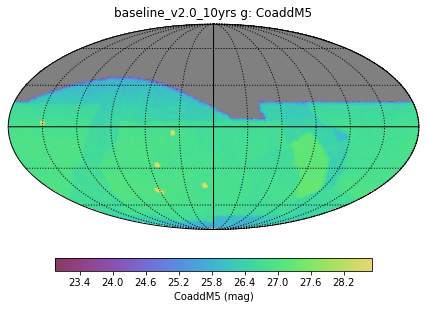

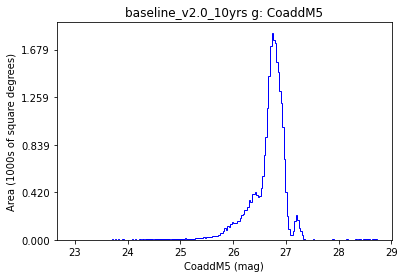

In [24]:
batches[run_name][bundle_name].plot()

Normally, you wouldn't do this in the same code that computed the metrics.

It created a set of files you can do further analysis on.
The `Comparing Runs` notebook shows how to use these files.
Here, we can just look at what the files were, and where it put them.

For each run, it created a `ResultsDb` database with summary data and metadata on the files it created:

In [25]:
!find $data_dir -name resultsDb_sqlite.db

/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_v2.0_10yrs/bulk_example/resultsDb_sqlite.db
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_retrofoot_v2.0_10yrs/bulk_example/resultsDb_sqlite.db
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/retro_baseline_v2.0_10yrs/bulk_example/resultsDb_sqlite.db
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/rolling_ns2_rw0.5_v2.0_10yrs/bulk_example/resultsDb_sqlite.db
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/rolling_ns3_rw0.5_v2.0_10yrs/bulk_example/resultsDb_sqlite.db
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/rolling_ns2_rw0.9_v2.0_10yrs/bulk_example/resultsDb_sqlite.db
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/rolling_ns3_rw0.9_v2.0_

It also created `numpy` save files with the metric values (and slicers):

In [26]:
!find $data_dir -name \*.npz

/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_v2.0_10yrs/bulk_example/baseline_v2_0_10yrs_OpenShutterFraction_UNIS.npz
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_v2.0_10yrs/bulk_example/baseline_v2_0_10yrs_Count_airmass_ONED.npz
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_v2.0_10yrs/bulk_example/baseline_v2_0_10yrs_CoaddM5_i_HEAL.npz
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_v2.0_10yrs/bulk_example/baseline_v2_0_10yrs_CoaddM5_g_HEAL.npz
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_retrofoot_v2.0_10yrs/bulk_example/baseline_retrofoot_v2_0_10yrs_OpenShutterFraction_UNIS.npz
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_retrofoot_v2.0_10yrs/bulk_example/baseline_retrofoot_v2_0_1

Finally, it created a set of plots, in both `pdf` and `png` formats:

In [27]:
!find $data_dir -name \*.pdf

/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_v2.0_10yrs/bulk_example/baseline_v2_0_10yrs_Count_airmass_ONED_BinnedData.pdf
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_v2.0_10yrs/bulk_example/baseline_v2_0_10yrs_CoaddM5_i_HEAL_SkyMap.pdf
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_v2.0_10yrs/bulk_example/baseline_v2_0_10yrs_CoaddM5_i_HEAL_Histogram.pdf
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_v2.0_10yrs/bulk_example/baseline_v2_0_10yrs_CoaddM5_g_HEAL_SkyMap.pdf
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_v2.0_10yrs/bulk_example/baseline_v2_0_10yrs_CoaddM5_g_HEAL_Histogram.pdf
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_retrofoot_v2.0_10yrs/bulk_example/baseline_retrofoot_v

In [28]:
!find $data_dir -name \*.png

/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_v2.0_10yrs/bulk_example/thumb.baseline_v2_0_10yrs_Count_airmass_ONED_BinnedData.png
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_v2.0_10yrs/bulk_example/thumb.baseline_v2_0_10yrs_CoaddM5_i_HEAL_SkyMap.png
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_v2.0_10yrs/bulk_example/thumb.baseline_v2_0_10yrs_CoaddM5_i_HEAL_Histogram.png
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_v2.0_10yrs/bulk_example/thumb.baseline_v2_0_10yrs_CoaddM5_g_HEAL_SkyMap.png
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_v2.0_10yrs/bulk_example/thumb.baseline_v2_0_10yrs_CoaddM5_g_HEAL_Histogram.png
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_retrofoot_v2.0_10yrs/bul

The results databases are `sqlite3` databases with metadata and summary information about the metrics run, including names of the files with the metrics and plots.
The `maf.ResultsDb` class provides access to this metadata; it's use is described in the `Comparing Runs` notebook.

It can also be used directly, for example by loading its contents into a `pandas.DataFrame`:

In [29]:
from os import path

resultsdb_fname = path.join(data_dir, opsim_runs[0], "bulk_example/resultsDb_sqlite.db")
resultsdb_fname

'/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_v2.0_10yrs/bulk_example/resultsDb_sqlite.db'

In [30]:
import sqlite3
import pandas as pd

with sqlite3.connect(resultsdb_fname) as con:
    df = pd.read_sql("SELECT * FROM metrics", con, index_col="metricId")

df

,metricName,slicerName,simDataName,sqlConstraint,metricMetadata,metricDataFile
metricId,,,,,,
1,OpenShutterFraction,UniSlicer,baseline_v2.0_10yrs,,,baseline_v2_0_10yrs_OpenShutterFraction_UNIS.npz
2,Count airmass,OneDSlicer,baseline_v2.0_10yrs,,,baseline_v2_0_10yrs_Count_airmass_ONED.npz
3,CoaddM5,HealpixSlicer,baseline_v2.0_10yrs,filter = 'i',i,baseline_v2_0_10yrs_CoaddM5_i_HEAL.npz
4,CoaddM5,HealpixSlicer,baseline_v2.0_10yrs,filter = 'g',g,baseline_v2_0_10yrs_CoaddM5_g_HEAL.npz


In [31]:
with sqlite3.connect(resultsdb_fname) as con:
    df = pd.read_sql(
        "SELECT * FROM plots NATURAL JOIN metrics",
        con,
        index_col=["metricId", "plotId"],
    )

df

plotType  \
metricId plotId               
2        1       BinnedData   
3        2           SkyMap   
         3        Histogram   
4        4           SkyMap   
         5        Histogram   

                                                          plotFile  \
metricId plotId                                                      
2        1       baseline_v2_0_10yrs_Count_airmass_ONED_BinnedD...   
3        2           baseline_v2_0_10yrs_CoaddM5_i_HEAL_SkyMap.pdf   
         3        baseline_v2_0_10yrs_CoaddM5_i_HEAL_Histogram.pdf   
4        4           baseline_v2_0_10yrs_CoaddM5_g_HEAL_SkyMap.pdf   
         5        baseline_v2_0_10yrs_CoaddM5_g_HEAL_Histogram.pdf   

                    metricName     slicerName          simDataName  \
metricId plotId                                                      
2        1       Count airmass     OneDSlicer  baseline_v2.0_10yrs   
3        2             CoaddM5  HealpixSlicer  baseline_v2.0_10yrs   
         3             CoaddM5  HealpixSlicer  baseline_v2.0_10yrs   
4        4             CoaddM5  HealpixSlicer  baseline_v2.0_10yrs   
         5             CoaddM5  HealpixSlicer  baseline_v2.0_10yrs   

                sqlConstraint metricMetadata  \
metricId plotId                                
2        1                                     
3        2       filter = 'i'              i   
         3       filter = 'i'              i   
4        4       filter = 'g'              g   
         5       filter = 'g'              g   

                                             metricDataFile  
metricId plotId                                              
2        1       baseline_v2_0_10yrs_Count_airmass_ONED.npz  
3        2           baseline_v2_0_10yrs_CoaddM5_i_HEAL.npz  
         3           baseline_v2_0_10yrs_CoaddM5_i_HEAL.npz  
4        4           baseline_v2_0_10yrs_CoaddM5_g_HEAL.npz  
         5           baseline_v2_0_10yrs_CoaddM5_g_HEAL.npz

In [32]:
with sqlite3.connect(resultsdb_fname) as con:
    df = pd.read_sql(
        "SELECT * FROM summarystats NATURAL JOIN metrics",
        con,
        index_col=["metricId", "statId"],
    )

df

summaryName   summaryValue           metricName  \
metricId statId                                                   
1        1         Identity       0.722458  OpenShutterFraction   
2        2             Mean   69566.000000        Count airmass   
         3              Rms  103403.912924        Count airmass   
         4           Median   13391.500000        Count airmass   
         5              Max  365361.000000        Count airmass   
         6              Min     831.000000        Count airmass   
         7       N(+3Sigma)       0.000000        Count airmass   
         8       N(-3Sigma)       0.000000        Count airmass   
         9            Count      30.000000        Count airmass   
         10        25th%ile    3339.000000        Count airmass   
         11        75th%ile   99346.750000        Count airmass   
3        12             Min      26.103001              CoaddM5   
         13          Median      26.287872              CoaddM5   
         14             Max      28.221760              CoaddM5   
4        15             Min      26.662000              CoaddM5   
         16          Median      26.816838              CoaddM5   
         17             Max      28.721744              CoaddM5   

                    slicerName          simDataName sqlConstraint  \
metricId statId                                                     
1        1           UniSlicer  baseline_v2.0_10yrs                 
2        2          OneDSlicer  baseline_v2.0_10yrs                 
         3          OneDSlicer  baseline_v2.0_10yrs                 
         4          OneDSlicer  baseline_v2.0_10yrs                 
         5          OneDSlicer  baseline_v2.0_10yrs                 
         6          OneDSlicer  baseline_v2.0_10yrs                 
         7          OneDSlicer  baseline_v2.0_10yrs                 
         8          OneDSlicer  baseline_v2.0_10yrs                 
         9          OneDSlicer  baseline_v2.0_10yrs                 
         10         OneDSlicer  baseline_v2.0_10yrs                 
         11         OneDSlicer  baseline_v2.0_10yrs                 
3        12      HealpixSlicer  baseline_v2.0_10yrs  filter = 'i'   
         13      HealpixSlicer  baseline_v2.0_10yrs  filter = 'i'   
         14      HealpixSlicer  baseline_v2.0_10yrs  filter = 'i'   
4        15      HealpixSlicer  baseline_v2.0_10yrs  filter = 'g'   
         16      HealpixSlicer  baseline_v2.0_10yrs  filter = 'g'   
         17      HealpixSlicer  baseline_v2.0_10yrs  filter = 'g'   

                metricMetadata  \
metricId statId                  
1        1                       
2        2                       
         3                       
         4                       
         5                       
         6                       
         7                       
         8                       
         9                       
         10                      
         11                      
3        12                  i   
         13                  i   
         14                  i   
4        15                  g   
         16                  g   
         17                  g   

                                                   metricDataFile  
metricId statId                                                    
1        1       baseline_v2_0_10yrs_OpenShutterFraction_UNIS.npz  
2        2             baseline_v2_0_10yrs_Count_airmass_ONED.npz  
         3             baseline_v2_0_10yrs_Count_airmass_ONED.npz  
         4             baseline_v2_0_10yrs_Count_airmass_ONED.npz  
         5             baseline_v2_0_10yrs_Count_airmass_ONED.npz  
         6             baseline_v2_0_10yrs_Count_airmass_ONED.npz  
         7             baseline_v2_0_10yrs_Count_airmass_ONED.npz  
         8             baseline_v2_0_10yrs_Count_airmass_ONED.npz  
         9             baseline_v2_0_10yrs_Count_airmass_ONED.npz  
         10            baseline_v2_